# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
# !pip install datasets --upgrade
import os
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('3.2.0', '4.49.0', '2.6.0+cu126')

In [2]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading Civil_Comments dataset

In [3]:
from datasets import load_dataset

# Load the Civil Comments dataset
raw_datasets = load_dataset("civil_comments")

# Display an example
print(raw_datasets["train"][0])


{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [4]:
print(raw_datasets["train"][34])

{'text': 'This bitch is nuts. Who would read a book by a woman.', 'toxicity': 0.8307692408561707, 'severe_toxicity': 0.10769230872392654, 'obscene': 0.6615384817123413, 'threat': 0.0, 'insult': 0.8307692408561707, 'identity_attack': 0.3384615480899811, 'sexual_explicit': 0.0615384615957737}


Assigning weights to different labels 

In [5]:
weights = {
    "toxicity": 0.30,
    "severe_toxicity": 0.15,
    "obscene": 0.15,
    "threat": 0.10,
    "insult": 0.15,
    "identity_attack": 0.10,
    "sexual_explicit": 0.05
}

Finding the weighted average of the labels and converting the output to binary i.e. toxic: 1 and non-toxic: 0<br/>
If the weighted average of the labels is greater than equal to 0.4 then mark the sentence as toxic in the dataset

In [6]:
def preprocess_labels(example):
    weighted_sum = sum(example[field] * weight for field, weight in weights.items())
    example["label"] = int(weighted_sum >= 0.4)
    return example

raw_datasets = raw_datasets.map(preprocess_labels)

In [7]:
label2id = {"non-toxic": 0, "toxic": 1}
id2label = {0: "non-toxic", 1: "toxic"}

## 2. Model & Tokenization

In [8]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

2

<img src = "figures/BERT_embed.png" width=500>

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
print(teacher_model.config.num_labels)
print(teacher_model.config.label2id)

2
{'non-toxic': 0, 'toxic': 1}


## 3. Preprocessing 

In [11]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

In [12]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1804874
    })
    validation: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 97320
    })
    test: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 97320
    })
})

In [13]:
# Since 'text' is the only input column we want to remove
column_dataset = ["text"]

# Remove unused input columns
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + [
    "toxicity", "severe_toxicity", "obscene", "threat",
    "insult", "identity_attack", "sexual_explicit"
])

# Rename 'label' to 'labels' for compatibility with HuggingFace Trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set format to PyTorch tensors
tokenized_datasets.set_format("torch")

tokenized_datasets


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1804874
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 97320
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 97320
    })
})

In [14]:
tokenized_datasets['train'][0]['input_ids']

tensor([ 101, 2023, 2003, 2061, 4658, 1012, 2009, 1005, 1055, 2066, 1010, 1005,
        2052, 2017, 2215, 2115, 2388, 2000, 3191, 2023, 1029, 1029, 1005, 2428,
        2307, 2801, 1010, 2092, 2589,  999,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [15]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"[CLS] this is so cool. it ' s like, ' would you want your mother to read this?? ' really great idea, well done! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

## 4. Preparing the dataloader

In [16]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(500))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(500))

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [19]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non-toxic",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non-toxic": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [20]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [21]:
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [22]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [23]:
from peft import LoraConfig, get_peft_model, TaskType
from torch.nn import Module

def get_lora_model(
    student : Module,
) -> None:
    """
    Configure LoRA adapters for the student model
    """
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
    )

    student = get_peft_model(student, lora_config)

    return student

model = get_lora_model(student=model)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model))

Teacher parameters : 109483778
Student parameters : 296450


In [25]:
count_parameters(model)/count_parameters(teacher_model) * 100

0.2707707072366465

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

## 6. Optimizer

In [26]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [27]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [28]:
import numpy as np
import evaluate
# Get the metric function
metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # preds have the same shape as the labels, after the argmax(-1) has been calculated
    # by preprocess_l"ogits_for_metrics but we need to shift the labels
    labels = labels[:, 1:].reshape(-1)
    preds = preds[:, :-1].reshape(-1)
    return metric.compute(predictions=preds, references=labels)

In [29]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [30]:
import numpy as np
import evaluate
# Get the metric function
metric = evaluate.load("accuracy")

## 9. Train

In [31]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []

for epoch in range(num_epochs):
    model.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model(**batch) 
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss (no distillation loss)
        loss_div = torch.tensor(0.0, device=device)
        train_loss_div += loss_div.item()
        # cosine loss (no cosine loss)
        loss_cos = torch.tensor(0.0, device=device)
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it (don't divide by 3 as distillation and cosine loss are 0)
        loss = (loss_cls + loss_div + loss_cos)
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/1565 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.0969:
  - Loss_cls: 0.0969
  - Loss_div: 0.0000
  - Loss_cos: 0.0000
Epoch at 1: Test Acc 0.9820
Epoch at 2: Train loss 0.0562:
  - Loss_cls: 0.0562
  - Loss_div: 0.0000
  - Loss_cos: 0.0000
Epoch at 2: Test Acc 0.9820
Epoch at 3: Train loss 0.0563:
  - Loss_cls: 0.0563
  - Loss_div: 0.0000
  - Loss_cos: 0.0000
Epoch at 3: Test Acc 0.9820
Epoch at 4: Train loss 0.0556:
  - Loss_cls: 0.0556
  - Loss_div: 0.0000
  - Loss_cos: 0.0000
Epoch at 4: Test Acc 0.9820
Epoch at 5: Train loss 0.0561:
  - Loss_cls: 0.0561
  - Loss_div: 0.0000
  - Loss_cos: 0.0000
Epoch at 5: Test Acc 0.9820
Avg Metric 0.982


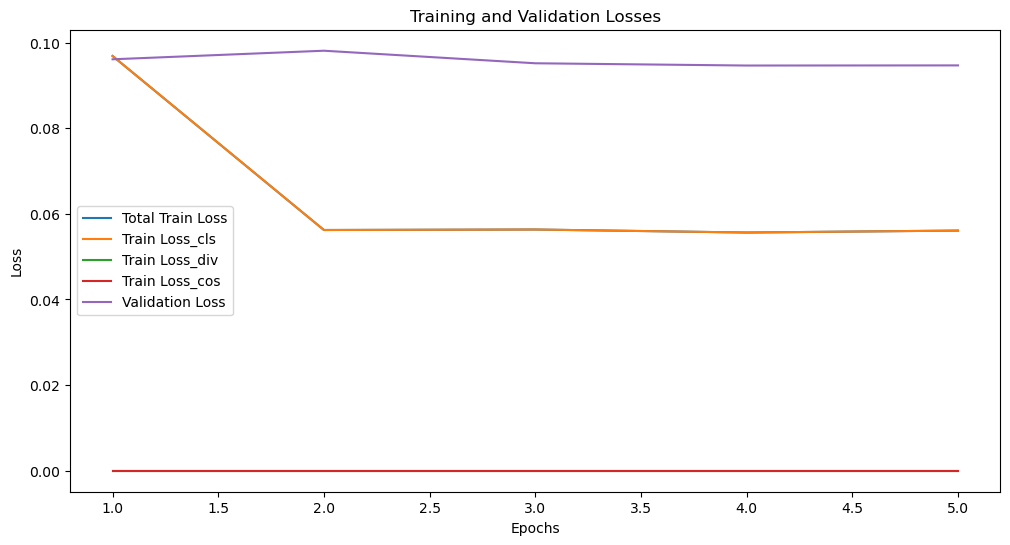

In [34]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Appendix (Teacher Model)

In [33]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/1565 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.0637:
Epoch at 1: Test Acc 0.9820
Epoch at 2: Train loss 0.0569:
Epoch at 2: Test Acc 0.9820
Epoch at 3: Train loss 0.0574:
Epoch at 3: Test Acc 0.9820
Epoch at 4: Train loss 0.0567:
Epoch at 4: Test Acc 0.9820
Epoch at 5: Train loss 0.0571:
Epoch at 5: Test Acc 0.9820
Avg Metric 0.982


In [35]:
import pickle
# Save the model and tokenizer
with open("../model/student_model_LoRA.pkl", "wb") as f:
    pickle.dump(model, f)
with open("../model/student_tokenizer_LoRA.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [36]:
# Load the model and tokenizer
with open("../model/student_model_LoRA.pkl", "rb") as f:
    model_odd = pickle.load(f)
with open("../model/student_tokenizer_LoRA.pkl", "rb") as f:
    tokenizer_odd = pickle.load(f)

In [37]:
def predict_toxicity(text, model, tokenizer, device):
    model.eval()
    
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    
    # Run the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
    
    # Map back to label
    id2label = {0: "non-toxic", 1: "toxic"}
    return {
        "text": text,
        "predicted_class": predicted_class,
        "label": id2label[predicted_class],
        "confidence": probs[0][predicted_class].item()
    }

In [41]:
sample_text = "You are a good boy."
result = predict_toxicity(sample_text, model_odd, tokenizer_odd, device)
print(result)

{'text': 'You are a good boy.', 'predicted_class': 0, 'label': 'non-toxic', 'confidence': 0.9923413991928101}
